In [1]:
import string

import cftime
import dask.diagnostics
import faceted
import fsspec
import nc_time_axis
import numpy as np
import xarray as xr

import cloud
import plotting
import times

In [2]:
plotting.configure_style()

In [3]:
DRIFTING_RUN = "gs://vcm-ml-experiments/spencerc/2022-01-22/n2f-25km-ml-corrected-v1-ensemble-unperturbed/fv3gfs_run"
STABLE_RUN = "gs://vcm-ml-experiments/spencerc/2022-06-30/n2f-25km-ml-corrected-updated-v3-unperturbed-seed-1/fv3gfs_run"

In [4]:
ORIGINAL_TRAINING_DATA = "gs://vcm-ml-experiments/spencerc/2022-03-12/n2f-25km-tapered-25-snoalb-nudging-tendencies-and-fluxes.zarr"
UPDATED_TRAINING_DATA = "gs://vcm-ml-experiments/spencerc/2022-07-07/n2f-25km-tapered-25-snoalb-nudging-tendencies-and-fluxes.zarr"
TRAINING_TIMES_FILE = "../workflows/ml-training/train.json"

In [5]:
training_times = times.open_times(TRAINING_TIMES_FILE)
original_training_data = xr.open_zarr(fsspec.get_mapper(ORIGINAL_TRAINING_DATA)).sel(time=training_times)
updated_training_data = xr.open_zarr(fsspec.get_mapper(UPDATED_TRAINING_DATA)).sel(time=training_times)

In [6]:
with dask.diagnostics.ProgressBar():
    original_range_minimum = original_training_data.air_temperature.min(["x", "y", "tile", "dataset", "time"]).compute()
    original_range_maximum = original_training_data.air_temperature.max(["x", "y", "tile", "dataset", "time"]).compute()
    updated_range_minimum = updated_training_data.air_temperature.min(["x", "y", "tile", "dataset", "time"]).compute()
    updated_range_maximum = updated_training_data.air_temperature.max(["x", "y", "tile", "dataset", "time"]).compute()

[########################################] | 100% Completed | 52.3s
[########################################] | 100% Completed | 49.8s
[########################################] | 100% Completed | 51.1s
[########################################] | 100% Completed | 48.5s


In [7]:
SECONDS_PER_DAY = 86400

def load_profiles(root, x=10, y=10, tile=0):
    dQ1 = SECONDS_PER_DAY * cloud.open_tape(root, "diags_3d").dQ1.isel(x=x, y=y, tile=tile).load()
    temperature = (
        cloud.open_tape(root, "state_after_timestep")
        .air_temperature.isel(x=x, y=y, tile=tile)
        .load()
    )
    return xr.merge([dQ1, temperature])

In [8]:
with dask.diagnostics.ProgressBar():
    drifting_profiles = load_profiles(DRIFTING_RUN).assign_coords(configuration="drifting").expand_dims("configuration")
    stable_profiles = load_profiles(STABLE_RUN).assign_coords(configuration="stable").expand_dims("configuration")

[########################################] | 100% Completed |  2min  7.1s
[########################################] | 100% Completed |  1min 59.1s
[########################################] | 100% Completed |  2min 15.4s
[########################################] | 100% Completed |  2min 10.5s


In [9]:
in_range_drifting = (
    (drifting_profiles.air_temperature <= original_range_maximum) &
    (drifting_profiles.air_temperature >= original_range_minimum)
)
in_range_stable = (
    (stable_profiles.air_temperature <= updated_range_maximum) &
    (stable_profiles.air_temperature >= updated_range_minimum)
)
in_range = xr.concat([in_range_drifting, in_range_stable], dim="configuration")

In [10]:
profiles = xr.concat([drifting_profiles, stable_profiles], dim="configuration")

In [11]:
TICKS = xr.cftime_range("2018", periods=6, freq="AS", calendar="julian").values
formatter = nc_time_axis.CFTimeFormatter("%Y", "julian")

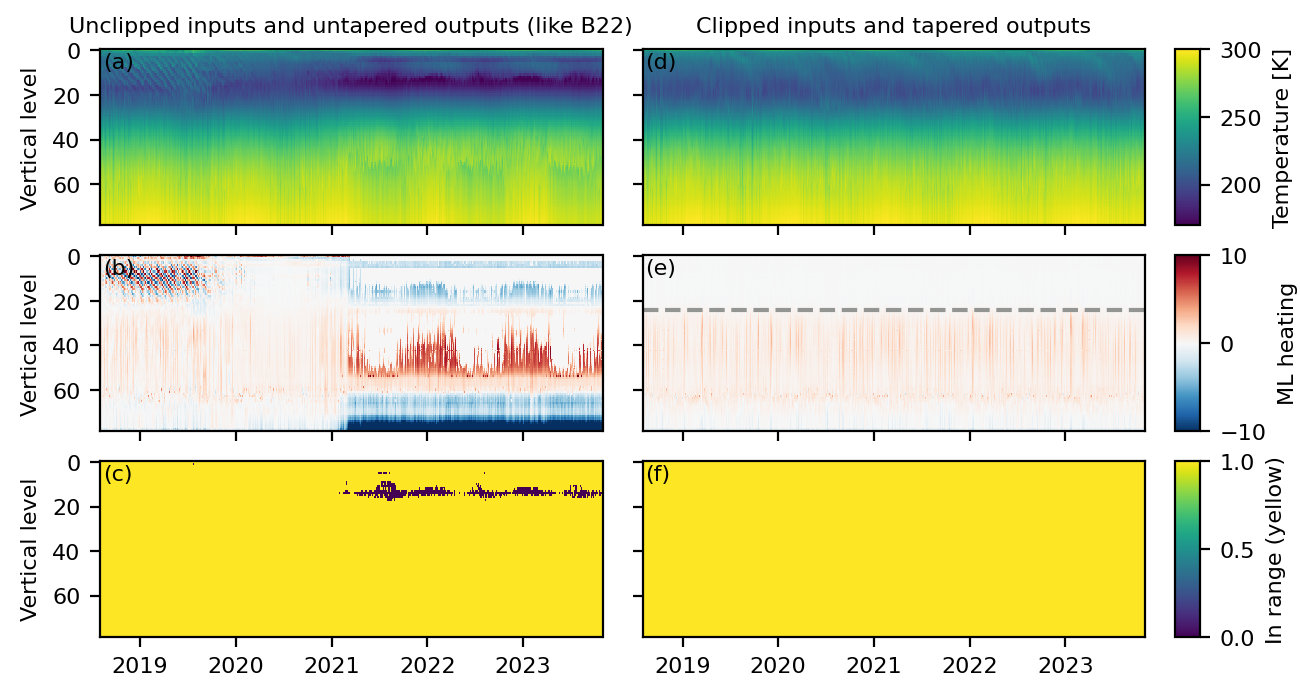

In [12]:
fig, (ax1, ax4, ax2, ax5, ax3, ax6), (cax1, cax2, cax3) = faceted.faceted(
    3,
    2,
    aspect=0.35,
    width=6.5,
    internal_pad=(0.2, 0.15),
    cbar_pad=0.15,
    cbar_mode="edge",
    cbar_location="right",
    right_pad=0.5,
    left_pad=0.5
)

configuration = "drifting"
p1 = (
    profiles.sel(time=slice(None, "2023-10"))
    .air_temperature.sel(configuration=configuration)
    .plot(ax=ax1, x="time", yincrease=False, add_colorbar=False, vmin=170, vmax=300)
)
p2 = (
    profiles.sel(time=slice(None, "2023-10"))
    .dQ1.sel(configuration=configuration)
    .plot(
        ax=ax2,
        vmin=-10,
        vmax=10,
        cmap="RdBu_r",
        x="time",
        yincrease=False,
        add_colorbar=False,
    )
)
p3 = (
    in_range.sel(time=slice(None, "2023-10"))
    .sel(configuration=configuration)
    .plot(ax=ax3, x="time", yincrease=False, add_colorbar=False, vmin=0, vmax=1)
)

fig.colorbar(p1, cax=cax1, label="Temperature [K]")
fig.colorbar(p2, cax=cax2, label="ML heating\nrate [K/day]")
fig.colorbar(p3, cax=cax3, label="In range (yellow)")
ax1.set_title("Unclipped inputs and untapered outputs (like B22)")
ax2.set_title("")
ax3.set_title("")

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("")
    ax.set_ylabel("Vertical level")
    ax.set_xticks(TICKS)
    ax.set_yticks(np.arange(0, 80, 20))
    ax.xaxis.set_major_formatter(formatter)
    ax.set_xlim(cftime.DatetimeJulian(2018, 8, 1), cftime.DatetimeJulian(2023, 11, 1))

configuration = "stable"
p1 = (
    profiles.sel(time=slice(None, "2023-10"))
    .air_temperature.sel(configuration=configuration)
    .plot(ax=ax4, x="time", yincrease=False, add_colorbar=False, vmin=170, vmax=300)
)
p2 = (
    profiles.sel(time=slice(None, "2023-10"))
    .dQ1.sel(configuration=configuration)
    .plot(
        ax=ax5,
        vmin=-10,
        vmax=10,
        cmap="RdBu_r",
        x="time",
        yincrease=False,
        add_colorbar=False,
    )
)
p3 = (
    in_range.sel(time=slice(None, "2023-10"))
    .sel(configuration=configuration)
    .plot(ax=ax6, x="time", yincrease=False, add_colorbar=False, vmin=0, vmax=1)
)

ax4.set_title(f"Clipped inputs and tapered outputs")
ax5.set_title("")
ax6.set_title("")

for ax in [ax4, ax5, ax6]:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks(TICKS)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_xlim(cftime.DatetimeJulian(2018, 8, 1), cftime.DatetimeJulian(2023, 11, 1))

ax5.axhline(24, color="gray", ls="--")

for ax, letter in zip((ax1, ax2, ax3, ax4, ax5, ax6), string.ascii_lowercase):
    ax.annotate(f"({letter})", xy=(0, 1), xytext=(1, -1), va="top", xycoords="axes fraction", textcoords="offset points")

fig.savefig("figures/figure-02.png", dpi=200, bbox_inches="tight")
fig.savefig("figures/figure-02.pdf", bbox_inches="tight", rasterized=True)